# Vehicle Dataset from CarDekho

## Dataset Overview
This dataset contains information about used cars listed on CarDekho, one of India's leading car search platforms. It includes details about vehicle specifications, pricing, and ownership history.

**Source:** [Kaggle - Vehicle Dataset from CarDekho](https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho)


## Data Dictionary

| Column | Data Type | Description |
|--------|-----------|-------------|
| **name** | object | Complete name and model of the vehicle |
| **year** | int64 | Manufacturing year of the vehicle |
| **selling_price** | int64 | Current selling price (in INR) |
| **km_driven** | int64 | Total kilometers driven by the vehicle |
| **fuel** | object | Fuel type (Petrol, Diesel, CNG, LPG, Electric) |
| **seller_type** | object | Type of seller (Individual, Dealer, Trustmark Dealer) |
| **transmission** | object | Transmission type (Manual, Automatic) |
| **owner** | object | Ownership history (First Owner, Second Owner, etc.) |


## Dataset Statistics
- **Total Records:** 4,340 vehicles
- **Time Period:** Various years (check `year` column for range)
- **No Missing Values:** All columns are complete (4,340 non-null entries)


## Potential Analysis Questions
- What factors most influence vehicle selling price?
- How does depreciation vary by brand, fuel type, or transmission?
- What's the relationship between km_driven and selling_price?
- Which seller types offer better deals?
- How does ownership history affect pricing?

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Getting the data - loading Df

In [2]:
vehicles_url = "https://raw.githubusercontent.com/jhlopesalves/data-science-notebooks/refs/heads/main/Python/projects/vehicles/data/CAR%20DETAILS%20FROM%20CAR%20DEKHO.csv"
vehicles = pd.read_csv(vehicles_url, usecols=lambda col: not col.startswith("Unnamed"))

### Data inspection / EDA (Exploratory Data Analysis)

In [3]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


#### Numeric columns

In [4]:
vehicles.select_dtypes("number").describe()

,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000


### Categorical columns

In [5]:
for col in ["fuel", "seller_type", "transmission", "owner"]:
    display(vehicles[col].value_counts(normalize=True, dropna=False).head(15).round(5))

fuel
Diesel      0.49608
Petrol      0.48917
CNG         0.00922
LPG         0.00530
Electric    0.00023
Name: proportion, dtype: float64

seller_type
Individual          0.74747
Dealer              0.22903
Trustmark Dealer    0.02350
Name: proportion, dtype: float64

transmission
Manual       0.89677
Automatic    0.10323
Name: proportion, dtype: float64

owner
First Owner             0.65253
Second Owner            0.25484
Third Owner             0.07005
Fourth & Above Owner    0.01866
Test Drive Car          0.00392
Name: proportion, dtype: float64

### Target Distribution

In [6]:
sns.set_color_codes("bright")

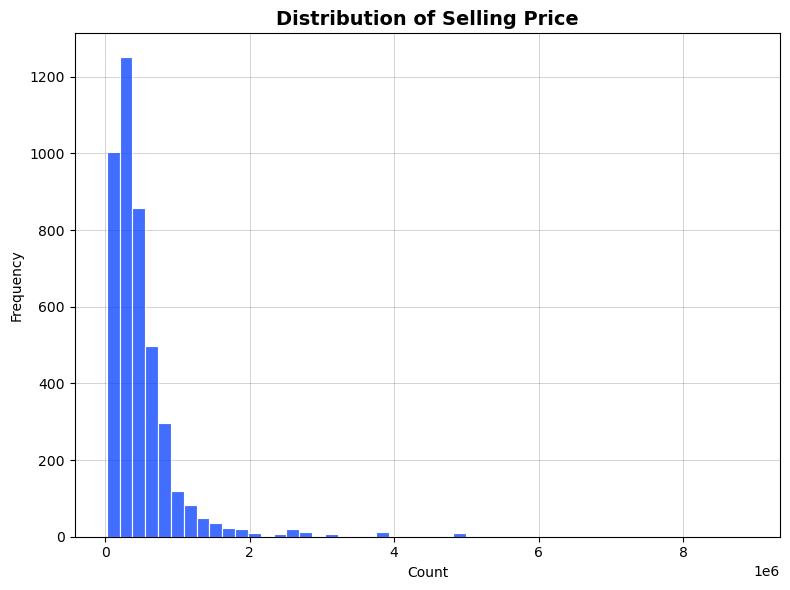

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=vehicles, x="selling_price", color="b", edgecolor="white", ax=ax, bins=50)
ax.set(xlabel="Count", ylabel="Frequency")
ax.set_title("Distribution of Selling Price", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.4, linewidth=0.6, color="grey")
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

### Train set / Test set split

In [8]:
from sklearn.model_selection import train_test_split

vehicles_full = vehicles.copy()

X = vehicles_full.drop(columns="selling_price")
y = vehicles_full["selling_price"]

# Stratify the split by binned target to keep the price distribution similar
# in both train and test sets (more stable, fairer offline evaluation).
price_bins = pd.qcut(y, q=10, duplicates="drop")

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=price_bins,
)

#### Plots

In [9]:
# Create training dataframe by combining X_train and y_train
vehicles_train = X_train.copy()
vehicles_train["selling_price"] = y_train

# Log-transform price (prices are right-skewed; use log1p for zeros)
vehicles_train["log_price"] = np.log1p(vehicles_train["selling_price"])

# Extract brand from name for plots
vehicles_train["brand"] = vehicles_train["name"].str.split().str[0]

# Car age = year - 2025
vehicles_train["car_age"] = 2025 - vehicles_train["year"]


# Sort categories by median price (intuitive order)
def median_order(col):
    return vehicles_train.groupby(col)["log_price"].median().sort_values(ascending=False).index


cat_cols = ["brand", "fuel", "seller_type", "transmission", "owner"]
for col in cat_cols:
    vehicles_train[f"{col}_order"] = vehicles_train[col].astype("category").cat.set_categories(median_order(col), ordered=True)

In [10]:
vehicles_train["brand"].value_counts()

brand
Maruti           1026
Hyundai           646
Mahindra          295
Tata              287
Honda             202
Ford              199
Toyota            169
Chevrolet         144
Renault           112
Volkswagen         87
Skoda              52
Audi               49
Nissan             48
Datsun             33
BMW                33
Fiat               30
Mercedes-Benz      29
Mitsubishi          6
Jaguar              5
Ambassador          4
Land                4
Volvo               3
Jeep                2
OpelCorsa           2
Kia                 1
Isuzu               1
Force               1
Daewoo              1
MG                  1
Name: count, dtype: int64

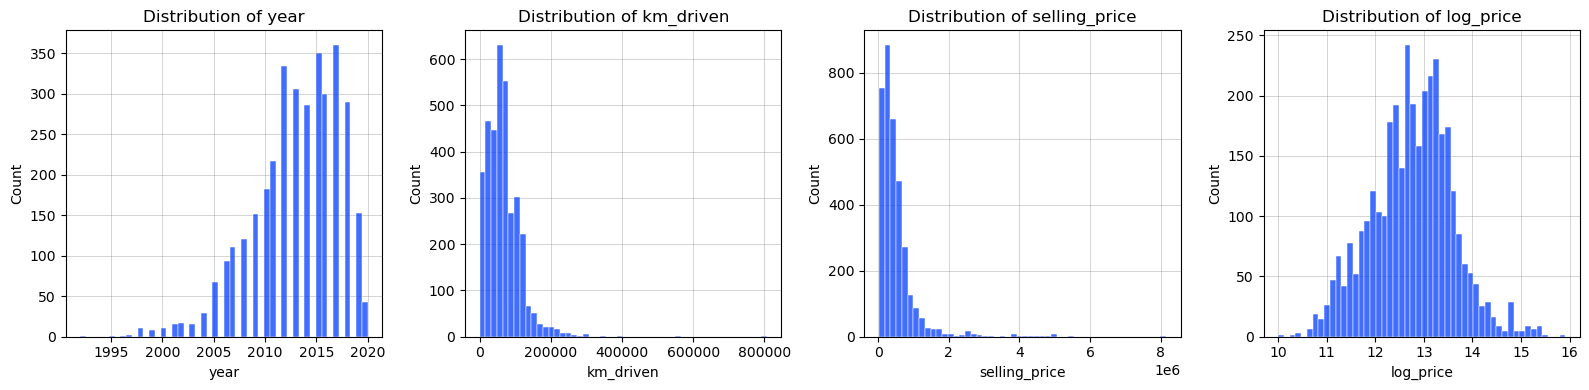

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
axes = axes.flatten()

numeric_cols = [col for col in vehicles_train.select_dtypes("number").columns if col in ["year", "selling_price", "km_driven", "log_price"]]
for i, col in enumerate(numeric_cols):
    sns.histplot(data=vehicles_train, x=col, color="b", edgecolor="white", bins=50, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel(col)
    axes[i].grid(True, alpha=0.4, linewidth=0.6, color="grey")
    axes[i].set_axisbelow(True)


plt.tight_layout()
plt.show()

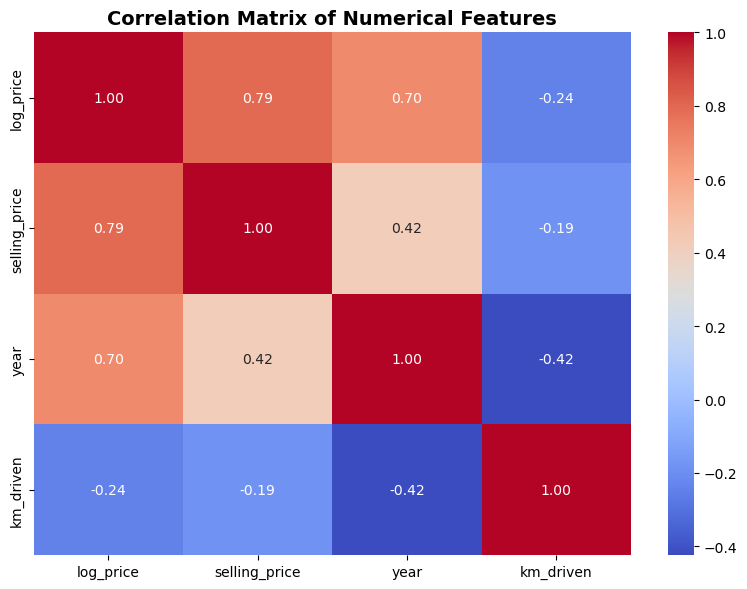

In [12]:
corr_matrix = vehicles_train[["log_price", "selling_price", "year", "km_driven"]].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
ax.set_title("Correlation Matrix of Numerical Features", fontweight="bold", fontsize=14)

plt.tight_layout()
plt.show()

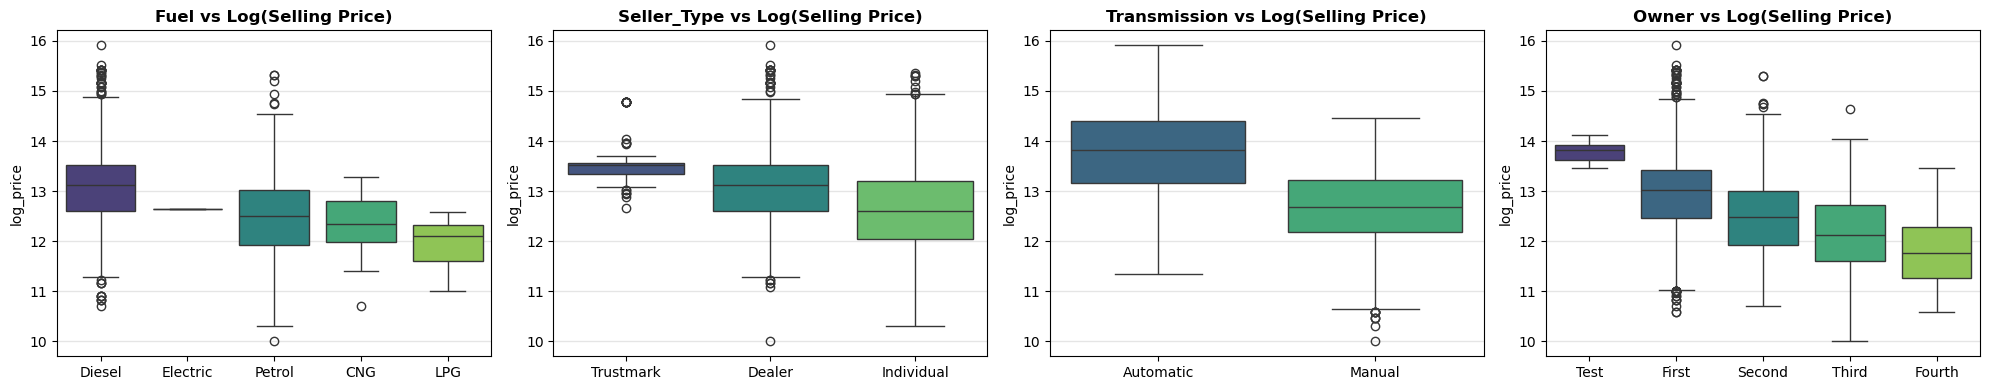

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
axes = axes.ravel()

for i, col in enumerate(["fuel", "seller_type", "transmission", "owner"]):
    sns.boxplot(
        data=vehicles_train,
        x=col + "_order",
        y="log_price",
        hue=col + "_order",
        palette="viridis",
        ax=axes[i],
        legend=False,
    )
    axes[i].set_title(f"{col.title()} vs Log(Selling Price)", fontweight="bold")
    axes[i].set_xlabel("")
    axes[i].grid(True, axis="y", alpha=0.2, linewidth=1, color="grey")

    # Get current tick labels and modify them
    labels = [label.get_text().split()[0] for label in axes[i].get_xticklabels()]
    axes[i].set_xticks(axes[i].get_xticks())
    axes[i].set_xticklabels(labels, rotation=0)

plt.tight_layout()
plt.show()

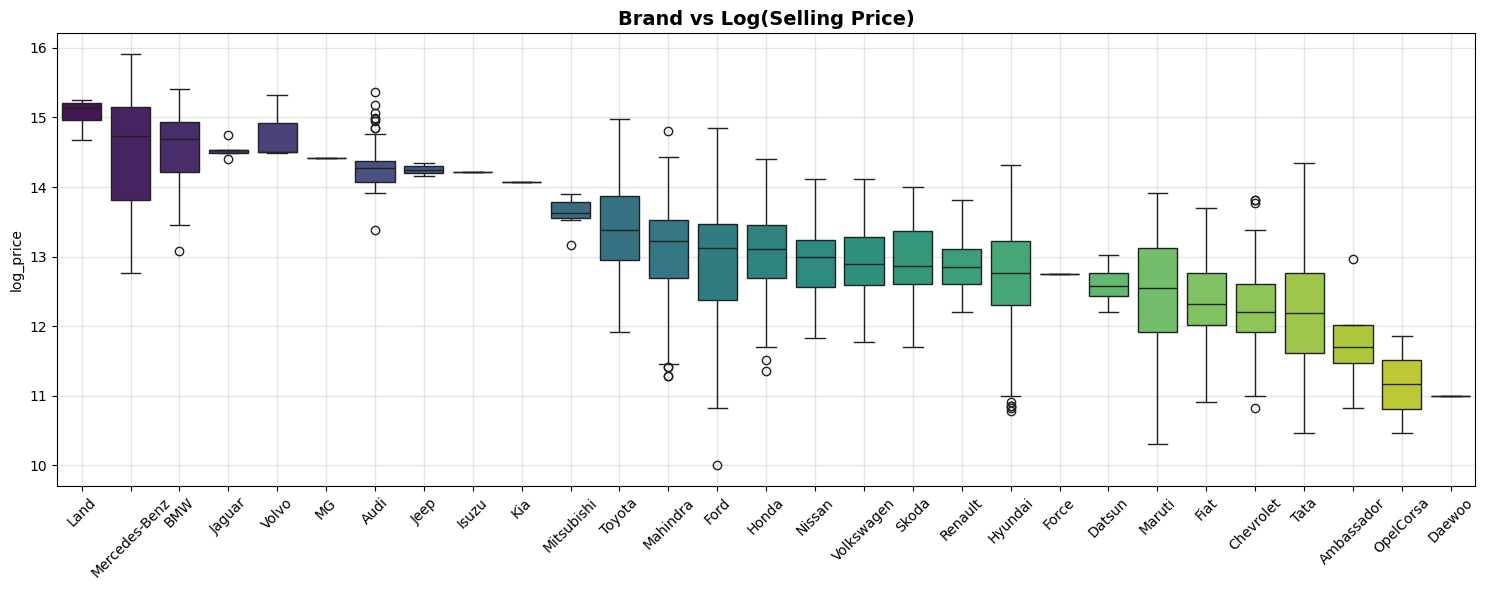

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.boxplot(
    data=vehicles_train,
    x="brand_order",
    y="log_price",
    hue="brand_order",
    palette="viridis",
    ax=ax,
    legend=False,
)
ax.set_title("Brand vs Log(Selling Price)", fontsize=14, fontweight="bold")
ax.set(xlabel="")
ax.grid(True, alpha=0.2, linewidth=1, color="grey")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Get the raw text
corpus = vehicles_train["name"].astype(str)

vec = CountVectorizer(min_df=10, stop_words=None)
X_bow = vec.fit_transform(corpus)

word_counts = pd.DataFrame({
    "word": vec.get_feature_names_out(),
    "count": X_bow.toarray().sum(axis=0),
})

print(f"Total unique words found (Vocabulary Size): {len(word_counts)}")
display(word_counts.sort_values("count", ascending=False).head(30))

Total unique words found (Vocabulary Size): 242


,word,count
135,maruti,1026
106,hyundai,646
133,mahindra,295
43,bsiv,293
66,diesel,291
191,tata,287
151,plus,257
188,swift,248
217,vxi,239
131,lxi,229


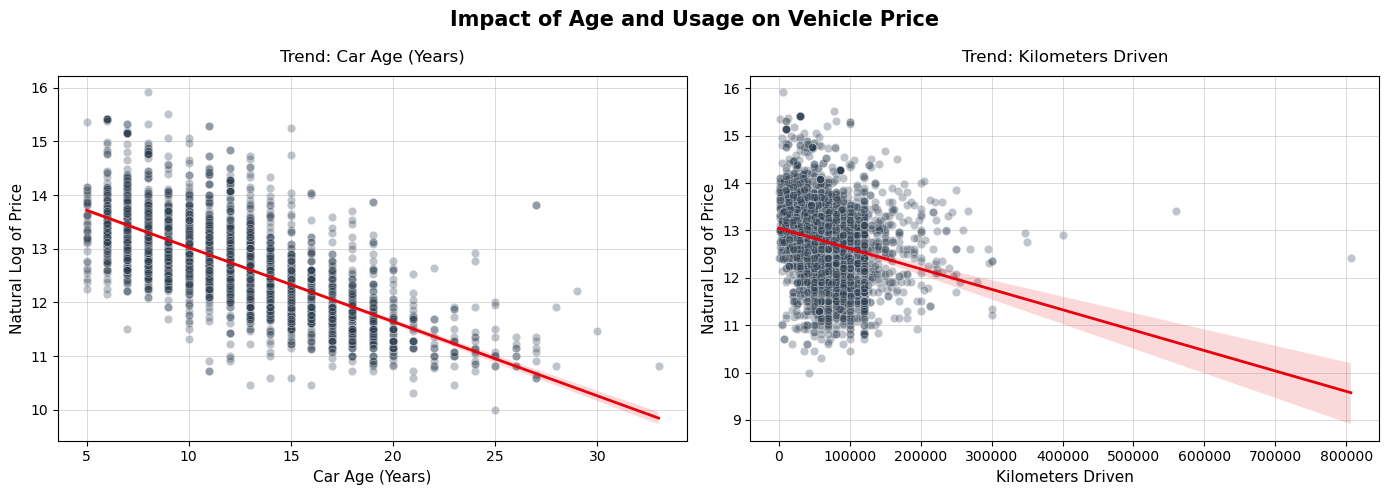

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 5))
axes = axes.flatten()

# Map column names to readable labels for better presentation
labels = {"car_age": "Car Age (Years)", "km_driven": "Kilometers Driven"}

for i, col in enumerate(["car_age", "km_driven"]):
    # define x as Age (independent) and y as Log Price (dependent).
    sns.scatterplot(
        data=vehicles_train,
        x=col,
        y="log_price",
        color="#2c3e50",
        alpha=0.3,
        ax=axes[i],
    )

    # This adds the analytical layer: showing the average trend (depreciation).
    sns.regplot(
        data=vehicles_train,
        x=col,
        y="log_price",
        scatter=False,
        color="r",
        line_kws={"linewidth": 2},
        ax=axes[i],
    )

    # Set improved labels and title for each subplot
    axes[i].set_xlabel(labels[col], fontsize=11)
    axes[i].set_ylabel("Natural Log of Price", fontsize=11)

    axes[i].set_title(f"Trend: {labels[col]}", fontsize=12, pad=10)

    axes[i].grid(True, linewidth=0.4, alpha=0.5, color="grey")

# Add a main title for the entire figure
fig.suptitle("Impact of Age and Usage on Vehicle Price", fontsize=15, fontweight="bold")

plt.tight_layout()
plt.show()

In [17]:
order_cols = [col for col in vehicles_train.columns if col.endswith("_order")]
vehicles_train.drop(columns=order_cols, inplace=True)
print(f"Dropped: {order_cols}")

Dropped: ['brand_order', 'fuel_order', 'seller_type_order', 'transmission_order', 'owner_order']


### Transformers / Pipelines 

In [18]:
from utils import BrandExtractor, YearToAgeTransformer

In [19]:
from typing import Callable

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from utils import densify_matrix, squeeze_dataframe

stop_words_brands = [
    "maruti",
    "hyundai",
    "mahindra",
    "tata",
    "honda",
    "ford",
    "toyota",
    "chevrolet",
    "renault",
    "volkswagen",
    "skoda",
    "audi",
    "nissan",
    "datsun",
    "bmw",
    "fiat",
    "mercedes-benz",
    "mercedes",
    "benz",
    "mg",
    "kia",
    "jeep",
    "volvo",
]


def make_feature_engineering(
    *,
    min_brand_count: int,
    reference_year: int | None = None,
    drop_name: bool = True,
) -> Pipeline:
    return Pipeline(
        steps=[
            ("brand_extractor", BrandExtractor(drop_name=drop_name, min_count=min_brand_count, other_value="OTHER")),
            ("year_to_age", YearToAgeTransformer(reference_year=reference_year, drop_year=True)),
        ]
    )


# Standardises categorical encoding across the project
# infrequent_if_exist ensures robustness against rare categories in test/val sets
def make_categorical_pipe(*, drop_first: bool = True, sparse_output: bool = False) -> Pipeline:
    return Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=5, drop="first" if drop_first else None, sparse_output=sparse_output))])


# Numerical preprocessing pipeline: handles scaling of continuous features
def make_numerical_pipe(*, transformer: TransformerMixin | None = None) -> Pipeline:
    if transformer is None:
        transformer = StandardScaler()
    return Pipeline(steps=[("num_scaler", transformer)])


# Textual preprocessing pipeline: extracts specs from 'name' column
def make_text_pipe(*, min_df: int = 10, max_df: float = 0.9, stop_words: list[str] | None = None) -> Pipeline:
    return Pipeline(
        steps=[
            # Flatten
            ("flatten", FunctionTransformer(squeeze_dataframe, validate=False)),
            # Vectorize
            ("bow", CountVectorizer(min_df=min_df, max_df=max_df, stop_words=stop_words, binary=True)),
            # Densify
            ("to_dense", FunctionTransformer(densify_matrix, validate=False)),
        ]
    )


# Column transformer factory: applies different preprocessing to different column types
def make_preprocessor(
    *,
    categorical_cols: list[str],
    numerical_cols: list[str],
    text_cols: list[str],
    numerical_transformer: TransformerMixin | None = None,
) -> ColumnTransformer:

    transformers = [
        ("categorical", make_categorical_pipe(), categorical_cols),
        ("numerical", make_numerical_pipe(transformer=numerical_transformer), numerical_cols),
        ("text", make_text_pipe(stop_words=stop_words_brands), text_cols),
    ]
    return ColumnTransformer(transformers=transformers, remainder="drop")


def make_vehicle_model(
    *,
    min_brand_count: int = 10,
    model: BaseEstimator | None = None,
    text_cols: list[str] | None = None,
    numerical_transformer: TransformerMixin | None = None,
    reference_year: int = 2025,
    log_target: bool = True,
) -> BaseEstimator:

    if model is None:
        model = LinearRegression()
    if text_cols is None:
        text_cols = ["name"]  # Default to using NLP

    categorical_cols = ["fuel", "seller_type", "transmission", "owner", "brand"]
    numerical_cols = ["km_driven", "car_age"]

    # If text_cols is empty list [], drop the name early.
    # If it has ["name"], keep it.
    should_drop_name = len(text_cols) == 0

    feature_eng = make_feature_engineering(
        min_brand_count=min_brand_count,
        reference_year=reference_year,
        drop_name=should_drop_name,
    )

    preprocessor = make_preprocessor(
        categorical_cols=categorical_cols,
        numerical_cols=numerical_cols,
        text_cols=text_cols,
        numerical_transformer=numerical_transformer,
    )

    full_pipeline = Pipeline(
        steps=[
            ("feature_engineering", clone(feature_eng)),
            ("preprocessor", clone(preprocessor)),
            ("model", clone(model)),
        ]
    )

    if log_target:
        return TransformedTargetRegressor(regressor=full_pipeline, func=np.log1p, inverse_func=np.expm1)

    return full_pipeline

### Baseline model

In [20]:
baseline = make_vehicle_model(
    min_brand_count=10,
    reference_year=2025,
    text_cols=["name"],
    log_target=True,
)

baseline.fit(X_train, y_train)

,regressor,Pipeline(step...egression())])
,transformer,None
,func,<ufunc 'log1p'>
,inverse_func,<ufunc 'expm1'>
,check_inverse,True
,steps,"[('brand_extractor', ...), ('year_to_age', ...)]"
,transform_input,None
,memory,None
,verbose,False
,name_col,'name'
,output_col,'brand'


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_baseline = baseline.predict(X_test)
r2 = r2_score(y_test, y_pred_baseline)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
mae = mean_absolute_error(y_test, y_pred_baseline)

print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R2 Score: 0.8371
RMSE: 270310.3435
MAE: 96133.0924


### Residual Plot

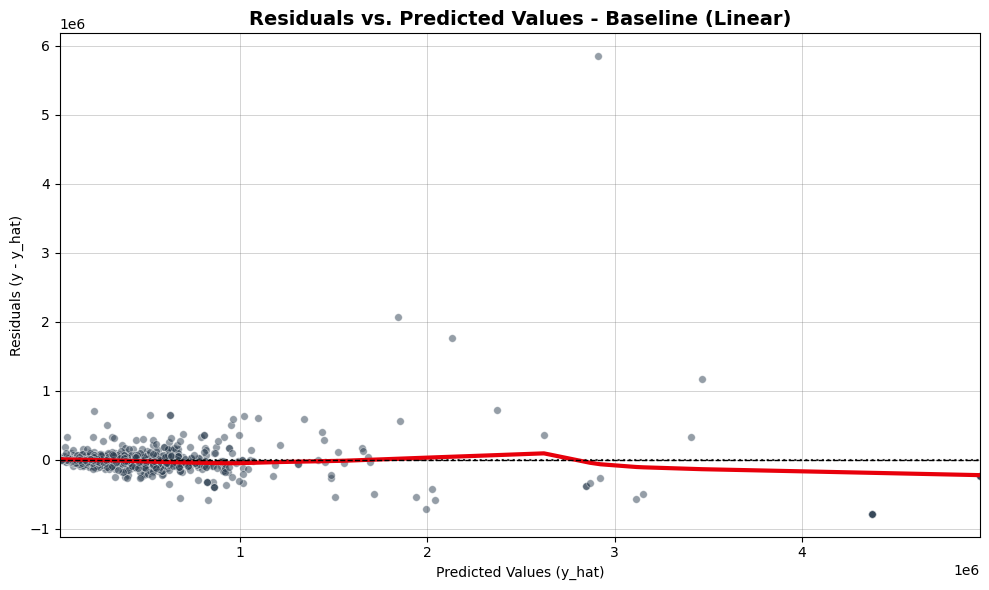

In [ ]:
y_pred_flatten = y_pred_baseline.flatten()
y_true_flatten = y_test.values.flatten()

# Calculate residuals
residuals = y_true_flatten - y_pred_flatten

fig, ax = plt.subplots(figsize=(10, 6))

# 'lowess=True' adds the smoothing line to reveal hidden patterns
# 'line_kws' styles that smoothing line (red for visibility)
sns.residplot(
    x=y_pred_flatten, y=residuals, lowess=True, color="#2c3e50", scatter_kws={"alpha": 0.5, "s": 30, "edgecolor": "w", "linewidths": 0.5}, line_kws={"color": "r", "lw": 3}, ax=ax
)

ax.set_title("Residuals vs. Predicted Values - Baseline (Linear)", fontsize=14, fontweight="bold")
ax.set_xlabel("Predicted Values (y_hat)")
ax.set_ylabel("Residuals (y - y_hat)")
ax.axhline(0, color="black", linestyle="--", linewidth=1)
ax.grid(True, alpha=0.4, linewidth=0.6, color="grey")
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

### Candidate model construction

In [23]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer

categorical_cols = ["fuel", "seller_type", "transmission", "owner", "brand"]
numerical_cols = ["km_driven", "car_age"]

# Baseline preprocessor
cat_pipe = make_categorical_pipe()
num_pipe = make_numerical_pipe()
text_pipe = make_text_pipe(stop_words=stop_words_brands)

baseline_preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", cat_pipe, categorical_cols),
        ("numerical", num_pipe, numerical_cols),
        ("text", text_pipe, ["name"]),
    ],
    remainder="drop",
)

# Polynomial preprocessor
poly_num_pipe = make_numerical_pipe(
    transformer=Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ]
    )
)

poly2_preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", cat_pipe, categorical_cols),
        ("numerical", poly_num_pipe, numerical_cols),
        ("text", text_pipe, ["name"]),
    ],
    remainder="drop",
)

# Spline preprocessor
spline_num_pipe = make_numerical_pipe(
    transformer=Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("splines", SplineTransformer(n_knots=8, degree=3, include_bias=False)),
        ]
    )
)

spline_preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", cat_pipe, categorical_cols),
        ("numerical", spline_num_pipe, numerical_cols),
        ("text", text_pipe, ["name"]),
    ],
    remainder="drop",
)

candidates = {
    "baseline_ridge": make_vehicle_model(
        model=Ridge(alpha=1.0, random_state=42),
        min_brand_count=10,
        text_cols=["name"],
        reference_year=2025,
        log_target=True,
    ),
    "spline_ridge": TransformedTargetRegressor(
        regressor=Pipeline(
            steps=[
                ("feature_engineering", make_feature_engineering(reference_year=2025, min_brand_count=10)),
                ("preprocessor", spline_preprocessor),
                ("model", Ridge(alpha=1.0, random_state=42)),
            ]
        ),
        func=np.log1p,
        inverse_func=np.expm1,
    ),
}


In [24]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer, StandardScaler

# Poly: Scale -> Create Polynomials
poly_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ]
)

# Spline: Scale -> Create Splines
spline_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("spline", SplineTransformer(n_knots=8, degree=3, include_bias=False)),
    ]
)

# Candidates Dictionary
candidates = {
    # Baseline: Standard Scaler (Default behavior)
    "baseline_ridge": make_vehicle_model(
        model=Ridge(alpha=1.0, random_state=42),
        min_brand_count=10,
        reference_year=2025,
        text_cols=[],  # Empty list = No NLP
        numerical_transformer=StandardScaler(),
    ),
    # Poly2: Inject the Poly Transformer
    "poly2_ridge": make_vehicle_model(model=Ridge(alpha=1.0, random_state=42), min_brand_count=10, reference_year=2025, text_cols=[], numerical_transformer=poly_transformer),
    # Spline: Inject the Spline Transformer
    "spline_ridge": make_vehicle_model(model=Ridge(alpha=1.0, random_state=42), min_brand_count=10, reference_year=2025, text_cols=[], numerical_transformer=spline_transformer),
}

In [25]:
for name, est in candidates.items():
    est.fit(X_train, y_train)
    preds = est.predict(X_test[:5])
    print(name, np.round(preds, 2))

baseline_ridge [217916.62 537563.89 481493.04 401044.27  54823.64]
poly2_ridge [210161.63 518839.89 491398.41 390047.46  63930.41]
spline_ridge [212401.79 522503.59 495493.18 393354.83  62166.72]


In [26]:
from typing import Literal

from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, cross_validate

SortMetric = Literal["rmse", "mae", "r2"]


def evaluate_candidates(
    candidates: dict[str, BaseEstimator],
    X,
    y,
    *,
    n_splits: int = 5,
    sort_by: str = "test_rmse",
    n_jobs: int = -1,
    verbose: bool = True,
) -> pd.DataFrame:

    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scoring = {"r2": "r2", "rmse": "neg_root_mean_squared_error", "mae": "neg_mean_absolute_error"}
    results_list = []

    for name, model in candidates.items():
        if verbose:
            print(f"Evaluating {name}...")
        cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, return_train_score=True)

        # Aggregate logic
        row = {"Model": name}
        for metric_name, scores in cv_results.items():
            if "time" in metric_name:
                continue
            # Flip negative scores
            if "neg_" in scoring.get(metric_name.replace("test_", "").replace("train_", ""), ""):
                scores = -scores
            row[f"{metric_name} (mean)"] = scores.mean()
            row[f"{metric_name} (std)"] = scores.std()
        results_list.append(row)

    df = pd.DataFrame(results_list)
    # Dynamic sort column finding
    sort_col = next((c for c in df.columns if sort_by in c and "(mean)" in c), "test_rmse (mean)")
    return df.sort_values(sort_col, ascending=("r2" not in sort_by)).reset_index(drop=True)

In [27]:
results = evaluate_candidates(
    candidates,
    X_train,
    y_train,
    n_splits=5,
    n_jobs=-1,
    sort_by="rmse",
)
display(results)

Evaluating baseline_ridge...
Evaluating poly2_ridge...
Evaluating spline_ridge...


,Model,test_r2 (mean),test_r2 (std),train_r2 (mean),train_r2 (std),test_rmse (mean),test_rmse (std),train_rmse (mean),train_rmse (std),test_mae (mean),test_mae (std),train_mae (mean),train_mae (std)
0,poly2_ridge,0.767004,0.046657,0.777415,0.009004,263519.251575,38552.764968,260820.367555,7579.758070,142411.752284,7489.849955,140774.564023,1960.963916
1,baseline_ridge,0.764098,0.044022,0.774642,0.008787,265433.603954,38035.410770,262447.195401,7599.995323,142650.848284,7877.177864,141013.953618,2017.726944
2,spline_ridge,0.763114,0.044226,0.773926,0.008571,265798.600105,36817.308786,262859.036941,7260.319271,142380.925128,7327.614283,140642.587806,1963.020310


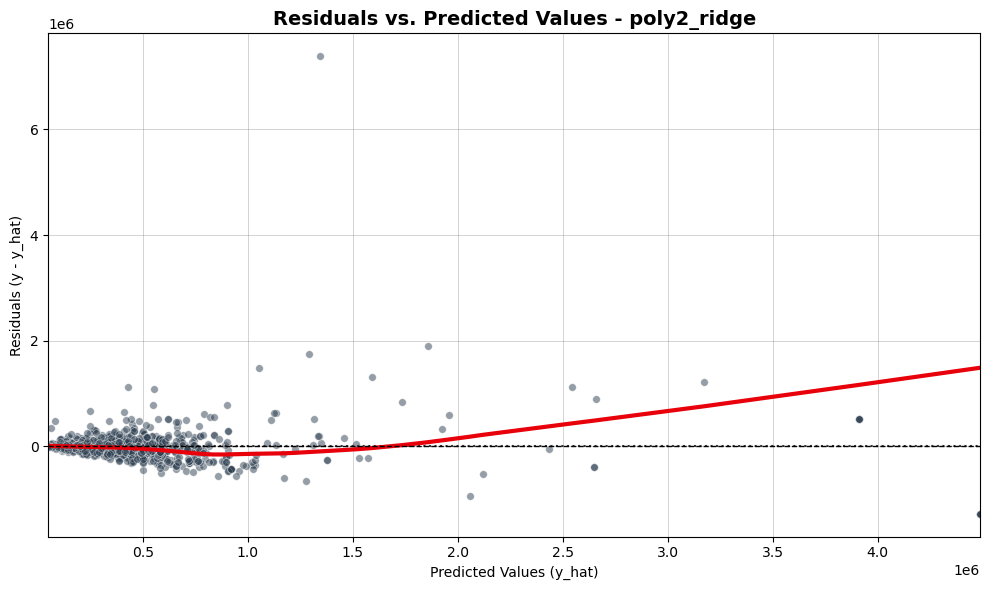

In [47]:
best_name = results.iloc[0]["Model"]
best_model = candidates[best_name]
y_pred_best = best_model.predict(X_test)

y_pred_flatten = y_pred_best.flatten()
y_true_flatten = y_test.values.flatten()

# Calculate residuals
residuals = y_true_flatten - y_pred_flatten

fig, ax = plt.subplots(figsize=(10, 6))

sns.residplot(
    x=y_pred_flatten,
    y=residuals,
    lowess=True,
    color="#2c3e50",
    scatter_kws={"alpha": 0.5, "s": 30, "edgecolor": "w", "linewidths": 0.5},
    line_kws={"color": "r", "lw": 3},
    ax=ax,
)

ax.set_title(f"Residuals vs. Predicted Values - {best_name}", fontsize=14, fontweight="bold")
ax.set_xlabel("Predicted Values (y_hat)")
ax.set_ylabel("Residuals (y - y_hat)")
ax.axhline(0, color="black", linestyle="--", linewidth=1)
ax.grid(True, alpha=0.4, linewidth=0.6, color="grey")
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

### Second Round of Candidate Models

In [29]:
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor

tree_candidates = {
    "baseline_ridge": make_vehicle_model(
        min_brand_count=10,
        reference_year=2025,
        text_cols=["name"],
        model=Ridge(alpha=1.0),
    ),
    "random_forest": make_vehicle_model(
        min_brand_count=10,
        reference_year=2025,
        text_cols=["name"],
        model=RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1),
    ),
    "hist_gradient_boosting": make_vehicle_model(
        min_brand_count=10,
        reference_year=2025,
        text_cols=["name"],
        model=HistGradientBoostingRegressor(learning_rate=0.1, max_iter=100, random_state=42),
    ),
}

tree_results = evaluate_candidates(
    candidates=tree_candidates,
    X=X_train,
    y=y_train,
    n_splits=5,
    n_jobs=-1,
    sort_by="rmse",
)

display(tree_results)

Evaluating baseline_ridge...
Evaluating random_forest...
Evaluating hist_gradient_boosting...


,Model,test_r2 (mean),test_r2 (std),train_r2 (mean),train_r2 (std),test_rmse (mean),test_rmse (std),train_rmse (mean),train_rmse (std),test_mae (mean),test_mae (std),train_mae (mean),train_mae (std)
0,baseline_ridge,0.828364,0.037086,0.861925,0.013219,226638.454737,38200.345561,205330.706465,12434.672377,99785.736187,7530.905972,90503.422505,2703.900433
1,random_forest,0.820059,0.067124,0.963734,0.003542,228132.345303,48116.269711,105173.338373,5284.233023,96326.045537,9712.041111,37805.122062,584.564989
2,hist_gradient_boosting,0.807507,0.041323,0.873406,0.009650,238876.078730,32474.803188,196631.390582,9297.065083,106219.187613,9115.564863,85216.011914,2153.749074


### Trying to save RF overfitting

In [30]:
from sklearn.model_selection import GridSearchCV

# Leaving the hyperparameters generic here because the GridSearch will override them
rf_base = make_vehicle_model(model=RandomForestRegressor(random_state=42, n_jobs=-1), min_brand_count=10, text_cols=["name"], log_target=True)

# "Should we limit depth?" and "Should we require more samples per leaf?"
param_grid = {
    # Try limiting depth to 15 or 20 levels (vs None/Infinite)
    "regressor__model__max_depth": [15, 20, None],
    # Try forcing leaves to contain at least 2 or 5 cars (vs 1)
    "regressor__model__min_samples_leaf": [1, 2, 5],
    # Check if adding more trees helps stability
    "regressor__model__n_estimators": [100, 200],
}

grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(f"Best MAE: {-grid_search.best_score_:,.0f}")
print("Best Parameters:")
display(grid_search.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best MAE: 100,004
Best Parameters:


{'regressor__model__max_depth': None,
 'regressor__model__min_samples_leaf': 1,
 'regressor__model__n_estimators': 200}

### Ridge vs. Random Forest

| Feature | **Ridge (Linear + NLP)** | **Random Forest (Trees + NLP)** |
| --- | --- | --- |
| **Test MAE (Cash Error)** | ₹99,785 (Lose ~₹3k per car) | ₹96,326 (Winner) |
| **Test RMSE (Large Errors)** | ₹226,638 (Winner) | ₹228,132 (More big blunders) |
| **Overfitting Gap** | Small ( vs ) - Safe | Huge ( vs ) - Risky |
| **Interpretation** | "Each word has a price tag." | "Complex rules define price." |



In [31]:
from sklearn.ensemble import VotingRegressor

# Define the Two Champions
model_ridge = make_vehicle_model(model=Ridge(alpha=1.0), min_brand_count=10, text_cols=["name"])

model_rf = make_vehicle_model(model=RandomForestRegressor(n_estimators=200, min_samples_leaf=1, max_depth=None, n_jobs=-1), min_brand_count=10, text_cols=["name"])

ensemble = VotingRegressor(estimators=[("ridge", model_ridge), ("rf", model_rf)], n_jobs=-1)


# Evaluate the Ensemble
# If this gets an MAE below ₹96,000, you have a new champion.
results_ensemble = evaluate_candidates(candidates={"ensemble_ridge_rf": ensemble}, X=X_train, y=y_train, n_splits=5, sort_by="mae")

display(results_ensemble.T)

Evaluating ensemble_ridge_rf...


,0
Model,ensemble_ridge_rf
test_r2 (mean),0.850167
test_r2 (std),0.052741
train_r2 (mean),0.931236
train_r2 (std),0.006549
test_rmse (mean),209102.100136
test_rmse (std),46272.422798
train_rmse (mean),144885.423534
train_rmse (std),8326.791763
test_mae (mean),90746.081383


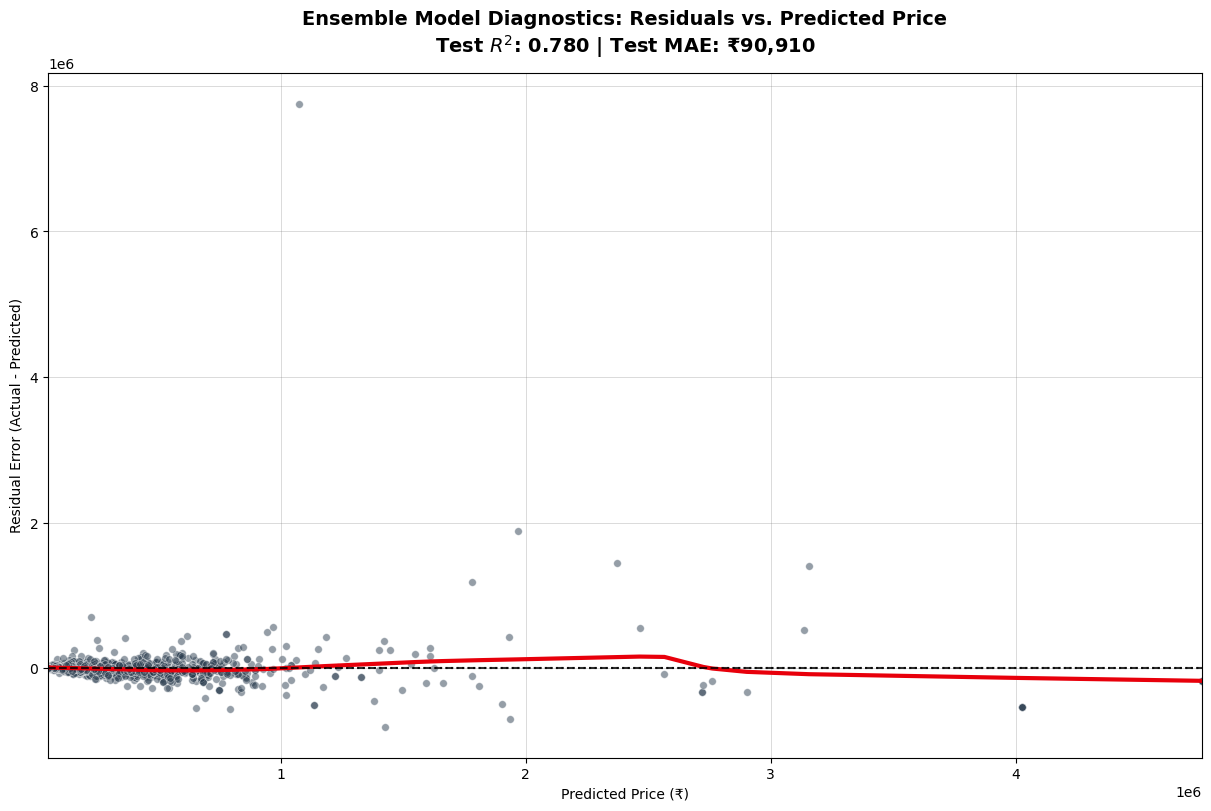

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = ensemble.predict(X_test)
residuals = y_test - y_pred

# Calculate final metrics for the title
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)

sns.residplot(
    x=y_pred, y=residuals, lowess=True, color="#2c3e50", scatter_kws={"alpha": 0.5, "s": 30, "edgecolor": "w", "linewidths": 0.5}, line_kws={"color": "r", "lw": 3}, ax=ax
)

ax.axhline(0, color="black", linestyle="--", linewidth=1.5, alpha=0.8)

ax.set_title(f"Ensemble Model Diagnostics: Residuals vs. Predicted Price\nTest $R^2$: {r2:.3f} | Test MAE: ₹{mae:,.0f}", fontsize=14, fontweight="bold", pad=15)

ax.set(xlabel="Predicted Price (₹)", ylabel="Residual Error (Actual - Predicted)")
ax.grid(True, alpha=0.4, linewidth=0.5, color="grey")

plt.show()

In [32]:
import os

import joblib

# FIT ON FULL DATA
print("Training the Final Ensemble on full training set...")
ensemble.fit(X_train, y_train)

# SAVE TO DISK
filename = "vehicle_price_model_v1.pkl"
joblib.dump(ensemble, filename)

print(f"Model saved to: {filename}")
print(f"Type: {type(ensemble).__name__}")
print(f"Size: {os.path.getsize(filename) / 1024 / 1024:.2f} MB")

Training the Final Ensemble on full training set...
Model saved to: vehicle_price_model_v1.pkl
Type: VotingRegressor
Size: 50.86 MB
